In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

#Machine Learning Models

In [0]:
#Creating db file from csv
disk_engine = create_engine('sqlite:///train.db')  


df= pd.read_csv("/content/drive/My Drive/Quora/final_features.csv")
df[0:100000].to_sql('data', disk_engine, if_exists='append')

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))






In [0]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [0]:
conn_r = create_connection(read_db)
data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10001;", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.599988,0.599988,0.749981,0.749981,0.666659,0.666659,0.0,0.0,0.0,9.0,76,73,71,70,0.313725,1,4,50,51,9,9,6.0,18.0,0.333333,5,3,-31.991828,-2.109376,-10.669669,128.697693,49.333217,66.031467,26.340297,31.452686,70.586283,48.097798,53.846307,-35.072345,5.232963,-48.288592,...,-9.287656,30.646452,-24.611163,2.909350,-0.206947,-37.296647,46.447291,13.365411,6.274764,22.941308,6.505387,-5.354055,8.322517,12.467183,-29.673280,-120.814000,39.613308,27.172053,-37.741688,7.759396,37.015703,-38.382387,-31.184749,54.143909,61.628811,-82.037285,9.068402,16.058424,30.889387,1.291776,-5.474643,20.655116,-35.461493,38.966929,-34.470354,-1.125351,24.922383,44.378096,60.847307,49.746906
2,0.333322,0.249994,0.249994,0.166664,0.285710,0.199998,1.0,0.0,3.0,8.5,60,60,55,61,0.307692,1,1,47,38,10,7,2.0,17.0,0.117647,2,0,111.408157,34.763150,29.102162,15.397933,69.775778,95.848822,69.050083,-3.732671,91.466773,46.278286,-4.678934,-11.112288,-24.702159,-1.640383,...,14.501244,57.171743,-11.585311,22.010850,-7.995472,26.613871,51.820588,40.059468,25.940609,-3.816466,-15.537732,-81.330356,-9.234465,-5.091736,-59.007987,-52.108898,-13.621048,3.796060,60.660925,-48.794096,94.323258,-94.726147,-24.705309,11.889583,-31.347494,-1.813668,-3.801079,22.989738,11.242509,27.802386,33.496301,-31.521701,-40.456908,17.178060,-44.733100,-8.080553,98.486536,19.759179,46.737219,62.509089
3,0.999988,0.888879,0.999988,0.888879,0.941171,0.941171,0.0,1.0,0.0,17.0,99,98,99,99,0.979798,3,7,98,98,17,17,16.0,34.0,0.470588,10,4,18.079498,14.351534,-138.675919,10.835533,128.928913,63.959430,45.356961,19.589643,165.082500,130.735843,-104.456178,38.016915,-18.394778,-31.952357,...,101.151266,23.563682,-42.061273,29.495019,35.020964,-46.052804,17.597581,140.262575,68.713921,-47.295176,164.520196,-71.960643,-89.648214,126.848527,21.884580,22.699260,86.036772,21.685461,81.600296,-74.471893,221.866886,-96.498821,-77.163042,71.820481,74.005571,-97.216554,-31.311871,50.181891,87.899431,-54.965005,39.055920,16.950459,17.844566,60.962834,-71.761846,-62.724857,16.446613,-2.563095,-4.408747,144.244452
4,0.499992,0.230767,0.857131,0.545450,0.599996,0.321427,0.0,1.0,13.0,21.5,76,48,42,51,0.150685,2,1,72,146,15,27,8.0,38.0,0.210526,3,1,51.751133,24.039557,-93.210800,-79.703619,68.876757,24.949938,65.042700,-3.706922,108.572114,86.239099,-28.365077,1.548292,71.165328,-1.263019,...,220.867781,59.451664,99.480782,72.031191,367.182055,-207.559376,81.609320,-114.576858,55.391183,-124.583977,64.094860,3.019246,16.603272,132.484609,-162.999005,41.692603,54.454638,-4.122963,-33.940042,-36.210106,192.722854,64.673956,58.131586,68.892389,26.717240,-177.876330,-166.455341,-67.568586,48.982885,-91.779459,16.263905,-46.293511,-129.092063,118.254089,-77.363715,-91.809121,-79.908986,231.497921,22.372251,119.285935
5,0.399992,0.399992,0.599988,0.249998,0.499995,0.294116,0.0,0.0,7.0,13.5,65,55,59,77,0.370968,1,1,61,99,10,16,4.0,26.0,0.153846,2,0,-22.235384,-0.261012,-25.480990,-27.390847,87.289456,113.660921,55.626319,-5.293016,107.676927,104.396277,47.228066,36.692173,-58.145861,-60.523181,...,105.929382,-26.411697,-62.627937,41.236740,98.630806,29.441047,21.113620,35.380008,125.200085,-115.548088,38.594006,-148.263039,45.469409,40.267366,-34.956100,-46.590411,149.360996,5.008830,80.068491,-18.666033,121.436575,-85.129152,-134.936953,-20.551227,-42.530528,43.542180,-47.627046,64.640554,25.399293,-109.540218,144.424010,26.339200,-85.993912,55.712965,-54.458808,-3

##Converting strings to numerics

In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    #print(i)

In [0]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))


##Random train test split( 70:30)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 218)
Number of data points in test data : (3000, 218)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6235714285714286 Class 1:  0.37642857142857145
---------- Distribution of output variable in test data ----------
Class 0:  0.6236666666666667 Class 1:  0.37633333333333335


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8853563385650031


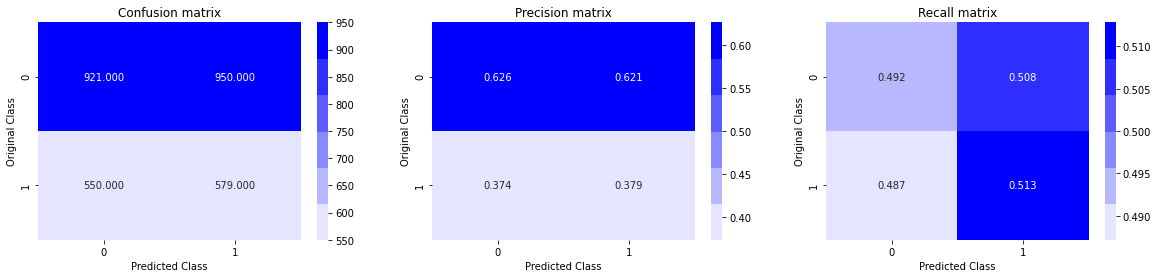

In [0]:
import scikitplot.metrics as skplt




# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)


plot_confusion_matrix(y_test, predicted_y)
plt.show()

##Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6622407052092435
For values of alpha =  0.0001 The log loss is: 0.6622407052092435
For values of alpha =  0.001 The log loss is: 0.5086440061811538
For values of alpha =  0.01 The log loss is: 0.5041113927207289
For values of alpha =  0.1 The log loss is: 0.49869961794331313
For values of alpha =  1 The log loss is: 0.5084947870358708
For values of alpha =  10 The log loss is: 0.5441067792448618


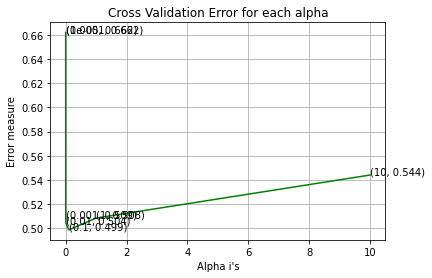

For values of best alpha =  0.1 The train log loss is: 0.48610110242533966
For values of best alpha =  0.1 The test log loss is: 0.49869961794331313
Total number of data points : 3000


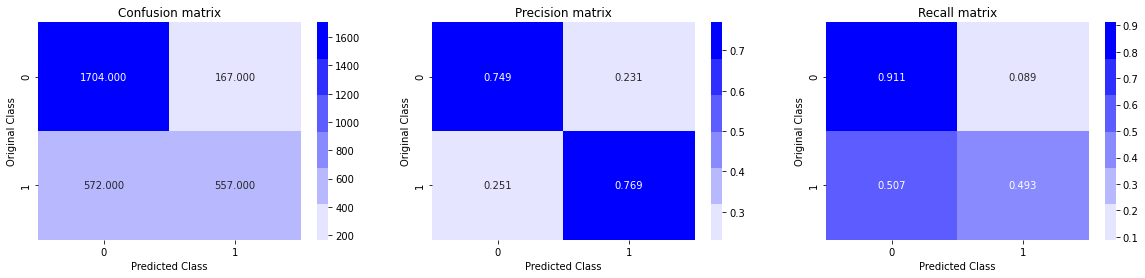

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6622407052092435
For values of alpha =  0.0001 The log loss is: 0.6622407052092435
For values of alpha =  0.001 The log loss is: 0.5666313421230619
For values of alpha =  0.01 The log loss is: 0.49831740723567436
For values of alpha =  0.1 The log loss is: 0.6045170718234409
For values of alpha =  1 The log loss is: 0.6421686134439731
For values of alpha =  10 The log loss is: 0.6622407052092435


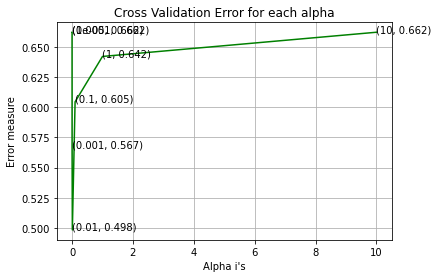

For values of best alpha =  0.01 The train log loss is: 0.4904819064912209
For values of best alpha =  0.01 The test log loss is: 0.49831740723567436
Total number of data points : 3000


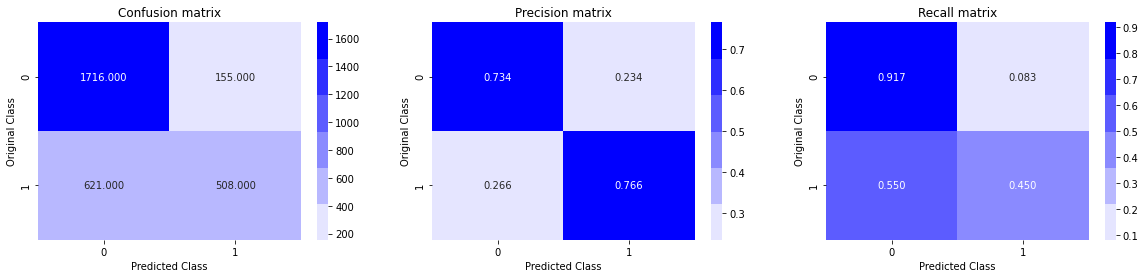

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##XGboost with hyperparameter tuning

In [0]:
import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

In [0]:
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

In [0]:
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=25, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='

In [0]:
model.best_params_


{'max_depth': 6, 'n_estimators': 50}

In [0]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=6,n_estimators=50)

In [0]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Train log loss =  0.2508140835486951  Test log loss =  0.36936489392196137


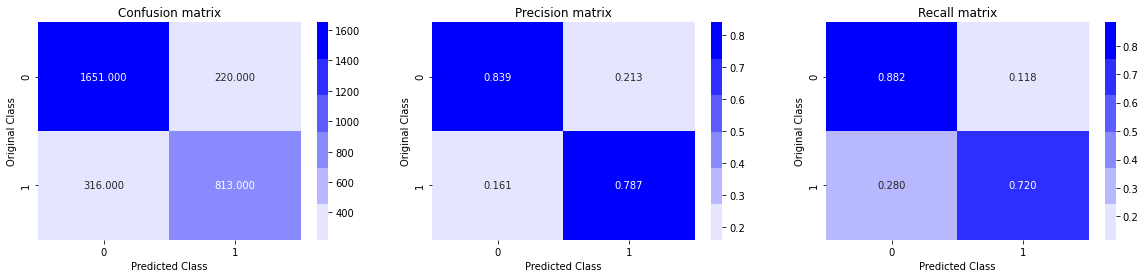

In [0]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)